<a href="https://colab.research.google.com/github/zachhanke/geektool-3/blob/master/demo_text_multiple_class_classification_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

base code borrowed from [this Google Colab Notebook](https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb).

Refactored by [Shuyi Wang](https://www.linkedin.com/in/shuyi-wang-b3955026/)

Please refer to [this Medium Article](https://medium.com/@wshuyi/how-to-do-text-binary-classification-with-bert-f1348a25d905) for detailed information.



In [0]:
#@title
!pip install bert-tensorflow
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
def pretty_print(result):
    df = pd.DataFrame([result]).T
    df.columns = ["values"]
    return df
def create_tokenizer_from_hub_module(bert_model_hub):
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(bert_model_hub)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

def make_features(dataset, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN):
    input_example = dataset.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
    features = bert.run_classifier.convert_examples_to_features(input_example, label_list, MAX_SEQ_LENGTH, tokenizer)
    return features

def create_model(bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      bert_model_hub,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(bert_model_hub, num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
#         f1_score = tf.contrib.metrics.f1_score(
#             label_ids,
#             predicted_labels)
#         auc = tf.metrics.auc(
#             label_ids,
#             predicted_labels)
#         recall = tf.metrics.recall(
#             label_ids,
#             predicted_labels)
#         precision = tf.metrics.precision(
#             label_ids,
#             predicted_labels) 
#         true_pos = tf.metrics.true_positives(
#             label_ids,
#             predicted_labels)
#         true_neg = tf.metrics.true_negatives(
#             label_ids,
#             predicted_labels)   
#         false_pos = tf.metrics.false_positives(
#             label_ids,
#             predicted_labels)  
#         false_neg = tf.metrics.false_negatives(
#             label_ids,
#             predicted_labels)
        return {
            "eval_accuracy": accuracy
#             "f1_score": f1_score,
#             "auc": auc,
#             "precision": precision,
#             "recall": recall,
#             "true_positives": true_pos,
#             "true_negatives": true_neg,
#             "false_positives": false_pos,
#             "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

def estimator_builder(bert_model_hub, OUTPUT_DIR, SAVE_SUMMARY_STEPS, SAVE_CHECKPOINTS_STEPS, label_list, LEARNING_RATE, num_train_steps, num_warmup_steps, BATCH_SIZE):

    # Specify outpit directory and number of checkpoint steps to save
    run_config = tf.estimator.RunConfig(
        model_dir=OUTPUT_DIR,
        save_summary_steps=SAVE_SUMMARY_STEPS,
        save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

    model_fn = model_fn_builder(
      bert_model_hub = bert_model_hub,
      num_labels=len(label_list),
      learning_rate=LEARNING_RATE,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps)

    estimator = tf.estimator.Estimator(
      model_fn=model_fn,
      config=run_config,
      params={"batch_size": BATCH_SIZE})
    return estimator, model_fn, run_config

def run_on_dfs(train, test, DATA_COLUMN, LABEL_COLUMN, 
               MAX_SEQ_LENGTH = 128,
              BATCH_SIZE = 32,
              LEARNING_RATE = 2e-5,
              NUM_TRAIN_EPOCHS = 3.0,
              WARMUP_PROPORTION = 0.1,
              SAVE_SUMMARY_STEPS = 100,
               SAVE_CHECKPOINTS_STEPS = 10000,
              bert_model_hub = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):

    label_list = train[LABEL_COLUMN].unique().tolist()
    
    tokenizer = create_tokenizer_from_hub_module(bert_model_hub)

    train_features = make_features(train, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN)
    test_features = make_features(test, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN)

    num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
    num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

    estimator, model_fn, run_config = estimator_builder(
                                  bert_model_hub, 
                                  OUTPUT_DIR, 
                                  SAVE_SUMMARY_STEPS, 
                                  SAVE_CHECKPOINTS_STEPS, 
                                  label_list, 
                                  LEARNING_RATE, 
                                  num_train_steps, 
                                  num_warmup_steps, 
                                  BATCH_SIZE)

    train_input_fn = bert.run_classifier.input_fn_builder(
        features=train_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=True,
        drop_remainder=False)

    estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

    test_input_fn = run_classifier.input_fn_builder(
        features=test_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=False,
        drop_remainder=False)

    result_dict = estimator.evaluate(input_fn=test_input_fn, steps=None)
    return result_dict, estimator
    
import random
random.seed(10)
OUTPUT_DIR = 'output'

    100% |████████████████████████████████| 71kB 8.6MB/s 


W0426 02:59:58.525446 139930685110144 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


----- you just need to focus from here ------

## Get your data

In [0]:
!wget https://github.com/wshuyi/demo-text-binary-classification-with-bert/raw/master/imdb-sample.pickle

--2019-04-26 02:59:59--  https://github.com/wshuyi/demo-text-binary-classification-with-bert/raw/master/imdb-sample.pickle
Resolving github.com (github.com)... 140.82.118.4, 140.82.118.3
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wshuyi/demo-text-binary-classification-with-bert/master/imdb-sample.pickle [following]
--2019-04-26 03:00:00--  https://raw.githubusercontent.com/wshuyi/demo-text-binary-classification-with-bert/master/imdb-sample.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940753 (3.8M) [application/octet-stream]
Saving to: ‘imdb-sample.pickle’

imdb-sample.pickle  100%[===================>]   3.76M  --.-KB/s    in 0.04s  

In [0]:
with open("imdb-sample.pickle", 'rb') as f:
    train, test = pickle.load(f)

In [0]:
len(train)

2000

In [0]:
train.sentiment.iloc[700:1300] = 2

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


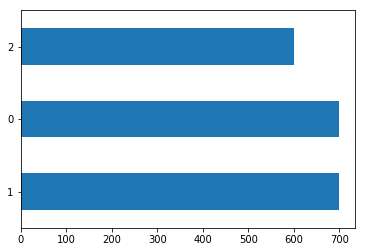

In [0]:
train.sentiment.value_counts().plot(kind='barh')

In [0]:
len(test)

1000

In [0]:
test.sentiment.iloc[350:650] = 2

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


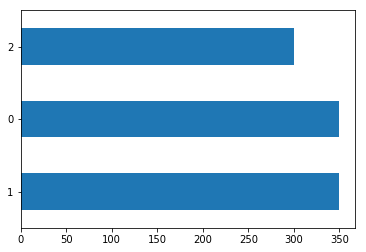

In [0]:
test.sentiment.value_counts().plot(kind='barh')

In [0]:
train = train.sample(len(train))

In [0]:
train.head()

,text,sentiment
1275,Definitely the worst movie I have ever seen......,2
108,"An overlong, but compelling retelling of the f...",1
1330,THE KING MAKER will doubtless be a success in ...,0
1333,When anyone comes into a film of this type of ...,0
553,I watched to movie today and it just blew my m...,1


In [0]:
myparam = {
        "DATA_COLUMN": "text",
        "LABEL_COLUMN": "sentiment",
        "LEARNING_RATE": 2e-5,
        "NUM_TRAIN_EPOCHS":2
    }

In [0]:
result, estimator = run_on_dfs(train, test, **myparam)

Instructions for updating:
Colocations handled automatically by placer.


W0426 03:00:09.641531 139930685110144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0426 03:00:11.650642 139930685110144 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 2000


I0426 03:00:14.896833 139930685110144 run_classifier.py:774] Writing example 0 of 2000


INFO:tensorflow:*** Example ***


I0426 03:00:14.906016 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:14.908714 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] definitely the worst movie i have ever seen . . . can somebody tell me where should have i laughed ? there ' s not a single hint or shadow of an idea . the three leading actors are pest ##ile ##ntial , especially the one ( i think it ' s aldo ) from sicily who _ can ' t _ make a sicilian accent ! ! ! not to say about the dream - like insertion about dracula . . . just another ex ##ped ##ient , drawn from the worst cabaret tradition , to make this " film " last a little longer . mass ##iro ##ni and lit ##ti ##zz ##etto do what they can , but this so - called movie [SEP]


I0426 03:00:14.912275 139930685110144 run_classifier.py:464] tokens: [CLS] definitely the worst movie i have ever seen . . . can somebody tell me where should have i laughed ? there ' s not a single hint or shadow of an idea . the three leading actors are pest ##ile ##ntial , especially the one ( i think it ' s aldo ) from sicily who _ can ' t _ make a sicilian accent ! ! ! not to say about the dream - like insertion about dracula . . . just another ex ##ped ##ient , drawn from the worst cabaret tradition , to make this " film " last a little longer . mass ##iro ##ni and lit ##ti ##zz ##etto do what they can , but this so - called movie [SEP]


INFO:tensorflow:input_ids: 101 5791 1996 5409 3185 1045 2031 2412 2464 1012 1012 1012 2064 8307 2425 2033 2073 2323 2031 1045 4191 1029 2045 1005 1055 2025 1037 2309 9374 2030 5192 1997 2019 2801 1012 1996 2093 2877 5889 2024 20739 9463 19909 1010 2926 1996 2028 1006 1045 2228 2009 1005 1055 28163 1007 2013 12071 2040 1035 2064 1005 1056 1035 2191 1037 22584 9669 999 999 999 2025 2000 2360 2055 1996 3959 1011 2066 23851 2055 18500 1012 1012 1012 2074 2178 4654 5669 11638 1010 4567 2013 1996 5409 19685 4535 1010 2000 2191 2023 1000 2143 1000 2197 1037 2210 2936 1012 3742 9711 3490 1998 5507 3775 13213 20082 2079 2054 2027 2064 1010 2021 2023 2061 1011 2170 3185 102


I0426 03:00:14.915160 139930685110144 run_classifier.py:465] input_ids: 101 5791 1996 5409 3185 1045 2031 2412 2464 1012 1012 1012 2064 8307 2425 2033 2073 2323 2031 1045 4191 1029 2045 1005 1055 2025 1037 2309 9374 2030 5192 1997 2019 2801 1012 1996 2093 2877 5889 2024 20739 9463 19909 1010 2926 1996 2028 1006 1045 2228 2009 1005 1055 28163 1007 2013 12071 2040 1035 2064 1005 1056 1035 2191 1037 22584 9669 999 999 999 2025 2000 2360 2055 1996 3959 1011 2066 23851 2055 18500 1012 1012 1012 2074 2178 4654 5669 11638 1010 4567 2013 1996 5409 19685 4535 1010 2000 2191 2023 1000 2143 1000 2197 1037 2210 2936 1012 3742 9711 3490 1998 5507 3775 13213 20082 2079 2054 2027 2064 1010 2021 2023 2061 1011 2170 3185 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:14.917879 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:14.920026 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 0)


I0426 03:00:14.922780 139930685110144 run_classifier.py:468] label: 2 (id = 0)


INFO:tensorflow:*** Example ***


I0426 03:00:14.929995 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:14.932780 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] an over ##long , but compelling re ##tell ##ing of the friendship between civil rights leader steve bi ##ko and donald woods . the first half of the film is the strongest where we see the bond formed between the two men , and how they help each other out , but the second half isn ' t as strong , due to the elimination of the bi ##ko character . still , its a compelling film with great performances by k ##line and washington , in the film that put the latter on the map . washington was also was nominated for best supporting actor for the first time . overall , a well made film that could have been trimmed down a bit . [SEP]


I0426 03:00:14.935497 139930685110144 run_classifier.py:464] tokens: [CLS] an over ##long , but compelling re ##tell ##ing of the friendship between civil rights leader steve bi ##ko and donald woods . the first half of the film is the strongest where we see the bond formed between the two men , and how they help each other out , but the second half isn ' t as strong , due to the elimination of the bi ##ko character . still , its a compelling film with great performances by k ##line and washington , in the film that put the latter on the map . washington was also was nominated for best supporting actor for the first time . overall , a well made film that could have been trimmed down a bit . [SEP]


INFO:tensorflow:input_ids: 101 2019 2058 10052 1010 2021 17075 2128 23567 2075 1997 1996 6860 2090 2942 2916 3003 3889 12170 3683 1998 6221 5249 1012 1996 2034 2431 1997 1996 2143 2003 1996 10473 2073 2057 2156 1996 5416 2719 2090 1996 2048 2273 1010 1998 2129 2027 2393 2169 2060 2041 1010 2021 1996 2117 2431 3475 1005 1056 2004 2844 1010 2349 2000 1996 9614 1997 1996 12170 3683 2839 1012 2145 1010 2049 1037 17075 2143 2007 2307 4616 2011 1047 4179 1998 2899 1010 1999 1996 2143 2008 2404 1996 3732 2006 1996 4949 1012 2899 2001 2036 2001 4222 2005 2190 4637 3364 2005 1996 2034 2051 1012 3452 1010 1037 2092 2081 2143 2008 2071 2031 2042 21920 2091 1037 2978 1012 102


I0426 03:00:14.938684 139930685110144 run_classifier.py:465] input_ids: 101 2019 2058 10052 1010 2021 17075 2128 23567 2075 1997 1996 6860 2090 2942 2916 3003 3889 12170 3683 1998 6221 5249 1012 1996 2034 2431 1997 1996 2143 2003 1996 10473 2073 2057 2156 1996 5416 2719 2090 1996 2048 2273 1010 1998 2129 2027 2393 2169 2060 2041 1010 2021 1996 2117 2431 3475 1005 1056 2004 2844 1010 2349 2000 1996 9614 1997 1996 12170 3683 2839 1012 2145 1010 2049 1037 17075 2143 2007 2307 4616 2011 1047 4179 1998 2899 1010 1999 1996 2143 2008 2404 1996 3732 2006 1996 4949 1012 2899 2001 2036 2001 4222 2005 2190 4637 3364 2005 1996 2034 2051 1012 3452 1010 1037 2092 2081 2143 2008 2071 2031 2042 21920 2091 1037 2978 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:14.941268 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:14.943922 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0426 03:00:14.946605 139930685110144 run_classifier.py:468] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I0426 03:00:14.965618 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:14.968452 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] the king maker will doubt ##less be a success in thailand where the similar ( but superior ) ' the legend of sur ##iy ##oth ##ai ' set box office records . the film directed by le ##k kit ##apa ##ra ##por ##n after a screenplay by sean casey based on historical fact in 154 ##7 siam has some amazingly beautiful visual elements but is di ##sar ##med by one of the corn ##iest , pedestrian scripts and story development on film . < br / > < br / > the event the picture relates is the arrival of the portuguese soldier of fortune fernando de gamma ( gary stretch ) whose vengeance for this father ' s murderer drives him to ship ##wr ##eck [SEP]


I0426 03:00:14.971789 139930685110144 run_classifier.py:464] tokens: [CLS] the king maker will doubt ##less be a success in thailand where the similar ( but superior ) ' the legend of sur ##iy ##oth ##ai ' set box office records . the film directed by le ##k kit ##apa ##ra ##por ##n after a screenplay by sean casey based on historical fact in 154 ##7 siam has some amazingly beautiful visual elements but is di ##sar ##med by one of the corn ##iest , pedestrian scripts and story development on film . < br / > < br / > the event the picture relates is the arrival of the portuguese soldier of fortune fernando de gamma ( gary stretch ) whose vengeance for this father ' s murderer drives him to ship ##wr ##eck [SEP]


INFO:tensorflow:input_ids: 101 1996 2332 9338 2097 4797 3238 2022 1037 3112 1999 6504 2073 1996 2714 1006 2021 6020 1007 1005 1996 5722 1997 7505 28008 14573 4886 1005 2275 3482 2436 2636 1012 1996 2143 2856 2011 3393 2243 8934 22068 2527 17822 2078 2044 1037 9000 2011 5977 9036 2241 2006 3439 2755 1999 16666 2581 25583 2038 2070 29350 3376 5107 3787 2021 2003 4487 10286 7583 2011 2028 1997 1996 9781 10458 1010 14662 14546 1998 2466 2458 2006 2143 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 2724 1996 3861 14623 2003 1996 5508 1997 1996 5077 5268 1997 7280 9158 2139 13091 1006 5639 7683 1007 3005 14096 2005 2023 2269 1005 1055 13422 9297 2032 2000 2911 13088 11012 102


I0426 03:00:14.974704 139930685110144 run_classifier.py:465] input_ids: 101 1996 2332 9338 2097 4797 3238 2022 1037 3112 1999 6504 2073 1996 2714 1006 2021 6020 1007 1005 1996 5722 1997 7505 28008 14573 4886 1005 2275 3482 2436 2636 1012 1996 2143 2856 2011 3393 2243 8934 22068 2527 17822 2078 2044 1037 9000 2011 5977 9036 2241 2006 3439 2755 1999 16666 2581 25583 2038 2070 29350 3376 5107 3787 2021 2003 4487 10286 7583 2011 2028 1997 1996 9781 10458 1010 14662 14546 1998 2466 2458 2006 2143 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 2724 1996 3861 14623 2003 1996 5508 1997 1996 5077 5268 1997 7280 9158 2139 13091 1006 5639 7683 1007 3005 14096 2005 2023 2269 1005 1055 13422 9297 2032 2000 2911 13088 11012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:14.977528 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:14.980293 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 2)


I0426 03:00:14.982983 139930685110144 run_classifier.py:468] label: 0 (id = 2)


INFO:tensorflow:*** Example ***


I0426 03:00:14.995577 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:14.998870 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] when anyone comes into a film of this type of film it ' s not without saying that an overdose of that great over - the - counter brain - medicine , suspension of disbelief , comes in mighty handy . < br / > < br / > jean ##ette macdonald plays two roles : anna / brig ##itt ##a , the woman who nelson eddy has ignored since the beginning of time , but who also is - - an angel sent to earth . < br / > < br / > my reaction when i saw this was a mute gasp of " hu ##nh ? " where have i seen this before ? it turns out , i have seen it [SEP]


I0426 03:00:15.001789 139930685110144 run_classifier.py:464] tokens: [CLS] when anyone comes into a film of this type of film it ' s not without saying that an overdose of that great over - the - counter brain - medicine , suspension of disbelief , comes in mighty handy . < br / > < br / > jean ##ette macdonald plays two roles : anna / brig ##itt ##a , the woman who nelson eddy has ignored since the beginning of time , but who also is - - an angel sent to earth . < br / > < br / > my reaction when i saw this was a mute gasp of " hu ##nh ? " where have i seen this before ? it turns out , i have seen it [SEP]


INFO:tensorflow:input_ids: 101 2043 3087 3310 2046 1037 2143 1997 2023 2828 1997 2143 2009 1005 1055 2025 2302 3038 2008 2019 26641 1997 2008 2307 2058 1011 1996 1011 4675 4167 1011 4200 1010 8636 1997 12537 1010 3310 1999 10478 18801 1012 1026 7987 1013 1028 1026 7987 1013 1028 3744 7585 10406 3248 2048 4395 1024 4698 1013 16908 12474 2050 1010 1996 2450 2040 5912 16645 2038 6439 2144 1996 2927 1997 2051 1010 2021 2040 2036 2003 1011 1011 2019 4850 2741 2000 3011 1012 1026 7987 1013 1028 1026 7987 1013 1028 2026 4668 2043 1045 2387 2023 2001 1037 20101 12008 1997 1000 15876 25311 1029 1000 2073 2031 1045 2464 2023 2077 1029 2009 4332 2041 1010 1045 2031 2464 2009 102


I0426 03:00:15.004678 139930685110144 run_classifier.py:465] input_ids: 101 2043 3087 3310 2046 1037 2143 1997 2023 2828 1997 2143 2009 1005 1055 2025 2302 3038 2008 2019 26641 1997 2008 2307 2058 1011 1996 1011 4675 4167 1011 4200 1010 8636 1997 12537 1010 3310 1999 10478 18801 1012 1026 7987 1013 1028 1026 7987 1013 1028 3744 7585 10406 3248 2048 4395 1024 4698 1013 16908 12474 2050 1010 1996 2450 2040 5912 16645 2038 6439 2144 1996 2927 1997 2051 1010 2021 2040 2036 2003 1011 1011 2019 4850 2741 2000 3011 1012 1026 7987 1013 1028 1026 7987 1013 1028 2026 4668 2043 1045 2387 2023 2001 1037 20101 12008 1997 1000 15876 25311 1029 1000 2073 2031 1045 2464 2023 2077 1029 2009 4332 2041 1010 1045 2031 2464 2009 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:15.007583 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:15.010280 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 2)


I0426 03:00:15.012942 139930685110144 run_classifier.py:468] label: 0 (id = 2)


INFO:tensorflow:*** Example ***


I0426 03:00:15.022701 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:15.025669 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i watched to movie today and it just blew my mind away . it is a real masterpiece of art and i don ' t understand why most of the people think it ' s garbage . the main idea of the movie - take your ego away and then you will have true power ! this was the main battle at the end of the movie and guy ritchie has shown that in a magnificent way . " the greatest enemy will hide in the last place you will ever look " - do you remember this from the movie ? because our true enemy is in us - it is our ego . . . that voice that always tells us that we are [SEP]


I0426 03:00:15.028429 139930685110144 run_classifier.py:464] tokens: [CLS] i watched to movie today and it just blew my mind away . it is a real masterpiece of art and i don ' t understand why most of the people think it ' s garbage . the main idea of the movie - take your ego away and then you will have true power ! this was the main battle at the end of the movie and guy ritchie has shown that in a magnificent way . " the greatest enemy will hide in the last place you will ever look " - do you remember this from the movie ? because our true enemy is in us - it is our ego . . . that voice that always tells us that we are [SEP]


INFO:tensorflow:input_ids: 101 1045 3427 2000 3185 2651 1998 2009 2074 8682 2026 2568 2185 1012 2009 2003 1037 2613 17743 1997 2396 1998 1045 2123 1005 1056 3305 2339 2087 1997 1996 2111 2228 2009 1005 1055 13044 1012 1996 2364 2801 1997 1996 3185 1011 2202 2115 13059 2185 1998 2059 2017 2097 2031 2995 2373 999 2023 2001 1996 2364 2645 2012 1996 2203 1997 1996 3185 1998 3124 20404 2038 3491 2008 1999 1037 12047 2126 1012 1000 1996 4602 4099 2097 5342 1999 1996 2197 2173 2017 2097 2412 2298 1000 1011 2079 2017 3342 2023 2013 1996 3185 1029 2138 2256 2995 4099 2003 1999 2149 1011 2009 2003 2256 13059 1012 1012 1012 2008 2376 2008 2467 4136 2149 2008 2057 2024 102


I0426 03:00:15.031080 139930685110144 run_classifier.py:465] input_ids: 101 1045 3427 2000 3185 2651 1998 2009 2074 8682 2026 2568 2185 1012 2009 2003 1037 2613 17743 1997 2396 1998 1045 2123 1005 1056 3305 2339 2087 1997 1996 2111 2228 2009 1005 1055 13044 1012 1996 2364 2801 1997 1996 3185 1011 2202 2115 13059 2185 1998 2059 2017 2097 2031 2995 2373 999 2023 2001 1996 2364 2645 2012 1996 2203 1997 1996 3185 1998 3124 20404 2038 3491 2008 1999 1037 12047 2126 1012 1000 1996 4602 4099 2097 5342 1999 1996 2197 2173 2017 2097 2412 2298 1000 1011 2079 2017 3342 2023 2013 1996 3185 1029 2138 2256 2995 4099 2003 1999 2149 1011 2009 2003 2256 13059 1012 1012 1012 2008 2376 2008 2467 4136 2149 2008 2057 2024 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:15.033760 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:15.036391 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0426 03:00:15.039245 139930685110144 run_classifier.py:468] label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 1000


I0426 03:00:24.230824 139930685110144 run_classifier.py:774] Writing example 0 of 1000


INFO:tensorflow:*** Example ***


I0426 03:00:24.236404 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:24.240964 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] bug juice changed my life . i know it sounds strange , odd , weird . but it did . i am from england , bug juice never aired there but five years ago i went on vacation with my family and saw it on the disney channel . once i saw this tv series i was hooked i wanted to go . it took a lot of convincing to my parents to allow my brother and i to go to wa ##zi ##yat ##ah . i have been going since i was 12 and it was my forth year this summer . if you are a teenager reading this come to this camp it changes your life . you make life long friends at wa [SEP]


I0426 03:00:24.244192 139930685110144 run_classifier.py:464] tokens: [CLS] bug juice changed my life . i know it sounds strange , odd , weird . but it did . i am from england , bug juice never aired there but five years ago i went on vacation with my family and saw it on the disney channel . once i saw this tv series i was hooked i wanted to go . it took a lot of convincing to my parents to allow my brother and i to go to wa ##zi ##yat ##ah . i have been going since i was 12 and it was my forth year this summer . if you are a teenager reading this come to this camp it changes your life . you make life long friends at wa [SEP]


INFO:tensorflow:input_ids: 101 11829 10869 2904 2026 2166 1012 1045 2113 2009 4165 4326 1010 5976 1010 6881 1012 2021 2009 2106 1012 1045 2572 2013 2563 1010 11829 10869 2196 4836 2045 2021 2274 2086 3283 1045 2253 2006 10885 2007 2026 2155 1998 2387 2009 2006 1996 6373 3149 1012 2320 1045 2387 2023 2694 2186 1045 2001 13322 1045 2359 2000 2175 1012 2009 2165 1037 2843 1997 13359 2000 2026 3008 2000 3499 2026 2567 1998 1045 2000 2175 2000 11333 5831 26139 4430 1012 1045 2031 2042 2183 2144 1045 2001 2260 1998 2009 2001 2026 5743 2095 2023 2621 1012 2065 2017 2024 1037 10563 3752 2023 2272 2000 2023 3409 2009 3431 2115 2166 1012 2017 2191 2166 2146 2814 2012 11333 102


I0426 03:00:24.246373 139930685110144 run_classifier.py:465] input_ids: 101 11829 10869 2904 2026 2166 1012 1045 2113 2009 4165 4326 1010 5976 1010 6881 1012 2021 2009 2106 1012 1045 2572 2013 2563 1010 11829 10869 2196 4836 2045 2021 2274 2086 3283 1045 2253 2006 10885 2007 2026 2155 1998 2387 2009 2006 1996 6373 3149 1012 2320 1045 2387 2023 2694 2186 1045 2001 13322 1045 2359 2000 2175 1012 2009 2165 1037 2843 1997 13359 2000 2026 3008 2000 3499 2026 2567 1998 1045 2000 2175 2000 11333 5831 26139 4430 1012 1045 2031 2042 2183 2144 1045 2001 2260 1998 2009 2001 2026 5743 2095 2023 2621 1012 2065 2017 2024 1037 10563 3752 2023 2272 2000 2023 3409 2009 3431 2115 2166 1012 2017 2191 2166 2146 2814 2012 11333 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:24.248984 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:24.251508 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0426 03:00:24.256335 139930685110144 run_classifier.py:468] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I0426 03:00:24.278239 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:24.280069 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] as many of today ' s movies are guilty of , the plot isn ' t exactly stellar , the movie doesn ' t move anyone , and certainly this won ' t warrant any award ( outside of blockbuster ##s ' perhaps ) . . . but then again , who really cares . < br / > < br / > eddie murphy and robert de ni ##ro team up to produce a very funny , at times hilarious , movie that i really enjoyed . russo and sha ##tner played their small parts well as well . man , i hope in the future my wife ages as well as miss renee has . < br / > < br / > moving [SEP]


I0426 03:00:24.283079 139930685110144 run_classifier.py:464] tokens: [CLS] as many of today ' s movies are guilty of , the plot isn ' t exactly stellar , the movie doesn ' t move anyone , and certainly this won ' t warrant any award ( outside of blockbuster ##s ' perhaps ) . . . but then again , who really cares . < br / > < br / > eddie murphy and robert de ni ##ro team up to produce a very funny , at times hilarious , movie that i really enjoyed . russo and sha ##tner played their small parts well as well . man , i hope in the future my wife ages as well as miss renee has . < br / > < br / > moving [SEP]


INFO:tensorflow:input_ids: 101 2004 2116 1997 2651 1005 1055 5691 2024 5905 1997 1010 1996 5436 3475 1005 1056 3599 17227 1010 1996 3185 2987 1005 1056 2693 3087 1010 1998 5121 2023 2180 1005 1056 10943 2151 2400 1006 2648 1997 27858 2015 1005 3383 1007 1012 1012 1012 2021 2059 2153 1010 2040 2428 14977 1012 1026 7987 1013 1028 1026 7987 1013 1028 5752 7104 1998 2728 2139 9152 3217 2136 2039 2000 3965 1037 2200 6057 1010 2012 2335 26316 1010 3185 2008 1045 2428 5632 1012 17023 1998 21146 18885 2209 2037 2235 3033 2092 2004 2092 1012 2158 1010 1045 3246 1999 1996 2925 2026 2564 5535 2004 2092 2004 3335 17400 2038 1012 1026 7987 1013 1028 1026 7987 1013 1028 3048 102


I0426 03:00:24.286766 139930685110144 run_classifier.py:465] input_ids: 101 2004 2116 1997 2651 1005 1055 5691 2024 5905 1997 1010 1996 5436 3475 1005 1056 3599 17227 1010 1996 3185 2987 1005 1056 2693 3087 1010 1998 5121 2023 2180 1005 1056 10943 2151 2400 1006 2648 1997 27858 2015 1005 3383 1007 1012 1012 1012 2021 2059 2153 1010 2040 2428 14977 1012 1026 7987 1013 1028 1026 7987 1013 1028 5752 7104 1998 2728 2139 9152 3217 2136 2039 2000 3965 1037 2200 6057 1010 2012 2335 26316 1010 3185 2008 1045 2428 5632 1012 17023 1998 21146 18885 2209 2037 2235 3033 2092 2004 2092 1012 2158 1010 1045 3246 1999 1996 2925 2026 2564 5535 2004 2092 2004 3335 17400 2038 1012 1026 7987 1013 1028 1026 7987 1013 1028 3048 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:24.289103 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:24.294055 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0426 03:00:24.296384 139930685110144 run_classifier.py:468] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I0426 03:00:24.304201 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:24.307717 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is one of the best movies i have ever seen . it is about true love and friendship . about turning your life around and doing something good for someone else . thomas bo larsen may play the same role he has done in so many other movies , but recently we have seen him in other roles which he does great too . but so what if he plays the same role that he has done in other movies he ' s perfect for that role . ulrich thom ##sen does a great job too . these two criminal " low - life ##s " are the best friends ever . they share everything and they do everything for each other no matter what [SEP]


I0426 03:00:24.312251 139930685110144 run_classifier.py:464] tokens: [CLS] this is one of the best movies i have ever seen . it is about true love and friendship . about turning your life around and doing something good for someone else . thomas bo larsen may play the same role he has done in so many other movies , but recently we have seen him in other roles which he does great too . but so what if he plays the same role that he has done in other movies he ' s perfect for that role . ulrich thom ##sen does a great job too . these two criminal " low - life ##s " are the best friends ever . they share everything and they do everything for each other no matter what [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 2028 1997 1996 2190 5691 1045 2031 2412 2464 1012 2009 2003 2055 2995 2293 1998 6860 1012 2055 3810 2115 2166 2105 1998 2725 2242 2204 2005 2619 2842 1012 2726 8945 20094 2089 2377 1996 2168 2535 2002 2038 2589 1999 2061 2116 2060 5691 1010 2021 3728 2057 2031 2464 2032 1999 2060 4395 2029 2002 2515 2307 2205 1012 2021 2061 2054 2065 2002 3248 1996 2168 2535 2008 2002 2038 2589 1999 2060 5691 2002 1005 1055 3819 2005 2008 2535 1012 19619 19438 5054 2515 1037 2307 3105 2205 1012 2122 2048 4735 1000 2659 1011 2166 2015 1000 2024 1996 2190 2814 2412 1012 2027 3745 2673 1998 2027 2079 2673 2005 2169 2060 2053 3043 2054 102


I0426 03:00:24.314795 139930685110144 run_classifier.py:465] input_ids: 101 2023 2003 2028 1997 1996 2190 5691 1045 2031 2412 2464 1012 2009 2003 2055 2995 2293 1998 6860 1012 2055 3810 2115 2166 2105 1998 2725 2242 2204 2005 2619 2842 1012 2726 8945 20094 2089 2377 1996 2168 2535 2002 2038 2589 1999 2061 2116 2060 5691 1010 2021 3728 2057 2031 2464 2032 1999 2060 4395 2029 2002 2515 2307 2205 1012 2021 2061 2054 2065 2002 3248 1996 2168 2535 2008 2002 2038 2589 1999 2060 5691 2002 1005 1055 3819 2005 2008 2535 1012 19619 19438 5054 2515 1037 2307 3105 2205 1012 2122 2048 4735 1000 2659 1011 2166 2015 1000 2024 1996 2190 2814 2412 1012 2027 3745 2673 1998 2027 2079 2673 2005 2169 2060 2053 3043 2054 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:24.321036 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:24.325736 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0426 03:00:24.327891 139930685110144 run_classifier.py:468] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I0426 03:00:24.340707 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:24.342491 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this movie took me by surprise . the opening credit sequence features nicely done animation . after that , we ' re plunged into a semi - che ##es ##y production , betray ##ing its low budget . the characters , typical american teens , are introduced slowly , with more personal detail than is usually found in movies like this . by the time the sh ##litz hits the fan , we know each one of the characters , and either like or hate them according to their distinct personalities . it ' s a slow up ##hill set - up , kind of like the ride up a slope of a really tall roller coaster . thankfully , once the action kicks in , [SEP]


I0426 03:00:24.344262 139930685110144 run_classifier.py:464] tokens: [CLS] this movie took me by surprise . the opening credit sequence features nicely done animation . after that , we ' re plunged into a semi - che ##es ##y production , betray ##ing its low budget . the characters , typical american teens , are introduced slowly , with more personal detail than is usually found in movies like this . by the time the sh ##litz hits the fan , we know each one of the characters , and either like or hate them according to their distinct personalities . it ' s a slow up ##hill set - up , kind of like the ride up a slope of a really tall roller coaster . thankfully , once the action kicks in , [SEP]


INFO:tensorflow:input_ids: 101 2023 3185 2165 2033 2011 4474 1012 1996 3098 4923 5537 2838 19957 2589 7284 1012 2044 2008 1010 2057 1005 2128 16687 2046 1037 4100 1011 18178 2229 2100 2537 1010 20895 2075 2049 2659 5166 1012 1996 3494 1010 5171 2137 13496 1010 2024 3107 3254 1010 2007 2062 3167 6987 2084 2003 2788 2179 1999 5691 2066 2023 1012 2011 1996 2051 1996 14021 24725 4978 1996 5470 1010 2057 2113 2169 2028 1997 1996 3494 1010 1998 2593 2066 2030 5223 2068 2429 2000 2037 5664 12857 1012 2009 1005 1055 1037 4030 2039 7100 2275 1011 2039 1010 2785 1997 2066 1996 4536 2039 1037 9663 1997 1037 2428 4206 11220 16817 1012 16047 1010 2320 1996 2895 14590 1999 1010 102


I0426 03:00:24.348011 139930685110144 run_classifier.py:465] input_ids: 101 2023 3185 2165 2033 2011 4474 1012 1996 3098 4923 5537 2838 19957 2589 7284 1012 2044 2008 1010 2057 1005 2128 16687 2046 1037 4100 1011 18178 2229 2100 2537 1010 20895 2075 2049 2659 5166 1012 1996 3494 1010 5171 2137 13496 1010 2024 3107 3254 1010 2007 2062 3167 6987 2084 2003 2788 2179 1999 5691 2066 2023 1012 2011 1996 2051 1996 14021 24725 4978 1996 5470 1010 2057 2113 2169 2028 1997 1996 3494 1010 1998 2593 2066 2030 5223 2068 2429 2000 2037 5664 12857 1012 2009 1005 1055 1037 4030 2039 7100 2275 1011 2039 1010 2785 1997 2066 1996 4536 2039 1037 9663 1997 1037 2428 4206 11220 16817 1012 16047 1010 2320 1996 2895 14590 1999 1010 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:24.352014 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:24.354697 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0426 03:00:24.358094 139930685110144 run_classifier.py:468] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I0426 03:00:24.371389 139930685110144 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0426 03:00:24.375922 139930685110144 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i am saliva ##ting for the sequels . i needed something to keep me from going insane with tension , anxiety ( what if it isn ' t as good ? ! ) , and constant lack of information . i needed something to calm me a little , something to pass the time , other than , of course , the matrix . this was just the thing . < br / > < br / > i found it inform ##ative ( like the part about ke ##anu ' s neck . . . ) and some of it was funny . i pit ##ied carrie - anne soo ##oo much when she said there was only one bathroom and all those guys . [SEP]


I0426 03:00:24.378046 139930685110144 run_classifier.py:464] tokens: [CLS] i am saliva ##ting for the sequels . i needed something to keep me from going insane with tension , anxiety ( what if it isn ' t as good ? ! ) , and constant lack of information . i needed something to calm me a little , something to pass the time , other than , of course , the matrix . this was just the thing . < br / > < br / > i found it inform ##ative ( like the part about ke ##anu ' s neck . . . ) and some of it was funny . i pit ##ied carrie - anne soo ##oo much when she said there was only one bathroom and all those guys . [SEP]


INFO:tensorflow:input_ids: 101 1045 2572 26308 3436 2005 1996 25815 1012 1045 2734 2242 2000 2562 2033 2013 2183 9577 2007 6980 1010 10089 1006 2054 2065 2009 3475 1005 1056 2004 2204 1029 999 1007 1010 1998 5377 3768 1997 2592 1012 1045 2734 2242 2000 5475 2033 1037 2210 1010 2242 2000 3413 1996 2051 1010 2060 2084 1010 1997 2607 1010 1996 8185 1012 2023 2001 2074 1996 2518 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 2179 2009 12367 8082 1006 2066 1996 2112 2055 17710 24076 1005 1055 3300 1012 1012 1012 1007 1998 2070 1997 2009 2001 6057 1012 1045 6770 6340 13223 1011 4776 17111 9541 2172 2043 2016 2056 2045 2001 2069 2028 5723 1998 2035 2216 4364 1012 102


I0426 03:00:24.382040 139930685110144 run_classifier.py:465] input_ids: 101 1045 2572 26308 3436 2005 1996 25815 1012 1045 2734 2242 2000 2562 2033 2013 2183 9577 2007 6980 1010 10089 1006 2054 2065 2009 3475 1005 1056 2004 2204 1029 999 1007 1010 1998 5377 3768 1997 2592 1012 1045 2734 2242 2000 5475 2033 1037 2210 1010 2242 2000 3413 1996 2051 1010 2060 2084 1010 1997 2607 1010 1996 8185 1012 2023 2001 2074 1996 2518 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 2179 2009 12367 8082 1006 2066 1996 2112 2055 17710 24076 1005 1055 3300 1012 1012 1012 1007 1998 2070 1997 2009 2001 6057 1012 1045 6770 6340 13223 1011 4776 17111 9541 2172 2043 2016 2056 2045 2001 2069 2028 5723 1998 2035 2216 4364 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0426 03:00:24.384233 139930685110144 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0426 03:00:24.387747 139930685110144 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0426 03:00:24.391127 139930685110144 run_classifier.py:468] label: 1 (id = 1)


INFO:tensorflow:Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f43bd98c828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0426 03:00:28.735858 139930685110144 estimator.py:201] Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f43bd98c828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0426 03:00:29.819284 139930685110144 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0426 03:00:32.692076 139930685110144 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0426 03:00:32.813238 139930685110144 deprecation.py:506] From <ipython-input-1-68baafc3d0f7>:67: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0426 03:00:32.857547 139930685110144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/learning_rate_decay_v2.py:321: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.cast instead.


W0426 03:00:32.939239 139930685110144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use tf.cast instead.


W0426 03:00:40.991983 139930685110144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:455: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Done calling model_fn.


I0426 03:00:41.013462 139930685110144 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0426 03:00:41.016839 139930685110144 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0426 03:00:44.453042 139930685110144 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0426 03:00:49.177044 139930685110144 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0426 03:00:49.373847 139930685110144 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into output/model.ckpt.


I0426 03:00:57.432362 139930685110144 basic_session_run_hooks.py:594] Saving checkpoints for 0 into output/model.ckpt.


INFO:tensorflow:loss = 1.200569, step = 0


I0426 03:01:13.656965 139930685110144 basic_session_run_hooks.py:249] loss = 1.200569, step = 0


INFO:tensorflow:global_step/sec: 0.989766


I0426 03:02:54.690356 139930685110144 basic_session_run_hooks.py:680] global_step/sec: 0.989766


INFO:tensorflow:loss = 0.71519285, step = 100 (101.036 sec)


I0426 03:02:54.692847 139930685110144 basic_session_run_hooks.py:247] loss = 0.71519285, step = 100 (101.036 sec)


INFO:tensorflow:Saving checkpoints for 125 into output/model.ckpt.


I0426 03:03:16.577717 139930685110144 basic_session_run_hooks.py:594] Saving checkpoints for 125 into output/model.ckpt.


INFO:tensorflow:Loss for final step: 0.67021245.


I0426 03:03:26.031431 139930685110144 estimator.py:359] Loss for final step: 0.67021245.


INFO:tensorflow:Calling model_fn.


I0426 03:03:26.586925 139930685110144 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0426 03:03:29.787088 139930685110144 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0426 03:03:38.368653 139930685110144 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-04-26T03:03:38Z


I0426 03:03:38.396859 139930685110144 evaluation.py:257] Starting evaluation at 2019-04-26T03:03:38Z


INFO:tensorflow:Graph was finalized.


I0426 03:03:40.026689 139930685110144 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0426 03:03:40.030109 139930685110144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from output/model.ckpt-125


I0426 03:03:40.037811 139930685110144 saver.py:1270] Restoring parameters from output/model.ckpt-125


INFO:tensorflow:Running local_init_op.


I0426 03:03:42.259374 139930685110144 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0426 03:03:42.482683 139930685110144 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-04-26-03:03:53


I0426 03:03:53.217282 139930685110144 evaluation.py:277] Finished evaluation at 2019-04-26-03:03:53


INFO:tensorflow:Saving dict for global step 125: eval_accuracy = 0.597, global_step = 125, loss = 0.85799223


I0426 03:03:53.221437 139930685110144 estimator.py:1979] Saving dict for global step 125: eval_accuracy = 0.597, global_step = 125, loss = 0.85799223


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 125: output/model.ckpt-125


I0426 03:03:55.311321 139930685110144 estimator.py:2039] Saving 'checkpoint_path' summary for global step 125: output/model.ckpt-125


In [0]:
print(result)

{'eval_accuracy': 0.597, 'loss': 0.85799223, 'global_step': 125}


In [0]:
!nvidia-smi

Fri Apr 26 03:04:56 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   8511MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  